In [ ]:
from google.colab import drive
from os import mkdir

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# #!cp '/content/gdrive/MyDrive/TFG Glaucoma GANS Alejandro /GAN/Pruebas_GAN/maps.tar.gz' .
# #!cp '/content/gdrive/My Drive/Investigacion/Proyectos retina/GAN/Pruebas_GAN/maps.tar.gz' .

!cp -r '/content/gdrive/MyDrive/TFG Glaucoma GANS Alejandro /GAN/Resultados/' .

cp: cannot open '/content/gdrive/MyDrive/TFG Glaucoma GANS Alejandro /GAN/Resultados/First-last-0.25-256x256/Resultados.gdoc' for reading: Operation not supported
cp: cannot open '/content/gdrive/MyDrive/TFG Glaucoma GANS Alejandro /GAN/Resultados/One-year-0.25-256x256/Resultados.gdoc' for reading: Operation not supported
cp: cannot open '/content/gdrive/MyDrive/TFG Glaucoma GANS Alejandro /GAN/Resultados/One-year-0.3-256x256-no525/Resultados.gdoc' for reading: Operation not supported


In [ ]:
# !cp -r 'models/' '/content/gdrive/MyDrive/TFG Glaucoma GANS Alejandro /GAN/Resultados/'

cp: cannot stat 'models/': No such file or directory


In [ ]:
# !cp 'first-last-0.3-256x256-no525_names-train.npz' '/content/gdrive/MyDrive/TFG Glaucoma GANS Alejandro /GAN/Resultados/'

cp: cannot stat 'first-last-0.3-256x256-no525_names-train.npz': No such file or directory


In [ ]:
# !cp Resultados/Final/One-year-0.3-256x256-no525-names/one-year-0.3-256x256-no525-names-test.npz .
# !cp Resultados/Final/One-year-0.3-256x256-no525-names/one-year-0.3-256x256-no525-names-train.npz .
# !cp Resultados/Final/One-year-0.3-256x256-no525-names/one-year-0.3-256x256-no525-names-train.npz .

!cp Resultados/Final/six-months-0.3-256x256/six-months-0.3-256x256-no525-names.zip .

In [ ]:
!tar -xf maps.tar.gz

In [ ]:
# !unzip first-last-0.3-256x256-no525_names.zip
# !unzip one-year-0.3-256x256-no525-names.zip
!unzip six-months-0.3-256x256-no525-names.zip

In [ ]:
root_path = 'six-months-0.3-256x256-no525-names'

train_filename = root_path + '-train.npz'
train_filename

'six-months-0.3-256x256-no525-names-train.npz'

In [ ]:
from os import mkdir

mkdir("models")
mkdir("plots")

In [ ]:
# load, split and scale the maps dataset ready for training
from os import listdir, path
from numpy import asarray, expand_dims
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from keras.applications.inception_v3 import preprocess_input
from numpy import savez_compressed
from json import dump


# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	filenames = []
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		filenames.append(filename)
		# load and resize the image
		pixels = load_img(path + filename)

		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		src_image, tar_image = pixels[:, :size[0]], pixels[:, size[0]:]
		src_list.append(src_image)
		tar_list.append(tar_image)
		
	return [asarray(src_list), asarray(tar_list)], filenames

# root_path = 'first-last-0.3-256x256-no525_names'
# root_path = 'one-year-0.3-256x256-no525-names'
root_path = 'six-months-0.3-256x256-no525-names'

# train path
train_path = path.join(root_path, 'train/')

# load dataset
([src_images, tar_images], _) = load_images(train_path, (256, 512))
print('Loaded: ', src_images.shape, tar_images.shape)

# save as compressed numpy array
train_filename = root_path + '-train.npz'
print(train_filename)
savez_compressed(train_filename, src_images, tar_images)
print('Saved dataset: ', train_filename)

# train path
test_path = path.join(root_path, 'test/')

# load dataset
([src_images, tar_images], filenames) = load_images(test_path, (256, 512))
print('Loaded: ', src_images.shape, tar_images.shape)

# save as compressed numpy array
test_filename = root_path + '-test.npz'
savez_compressed(test_filename, src_images, tar_images)
print('Saved dataset: ', test_filename)

with open('six_months_test_image_order.json', 'w') as f: 
	dump(filenames, f, indent=4)

Loaded:  (61, 256, 256, 3) (61, 256, 256, 3)
six-months-0.3-256x256-no525-names-train.npz
Saved dataset:  six-months-0.3-256x256-no525-names-train.npz
Loaded:  (26, 256, 256, 3) (26, 256, 256, 3)
Saved dataset:  six-months-0.3-256x256-no525-names-test.npz


In [ ]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
# data = load('maps_256.npz')
data = load(train_filename)
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)


# plot source images
# n_samples = 3
# for i in range(n_samples):
# 	pyplot.subplot(2, n_samples, 1 + i)
# 	pyplot.axis('off')
# 	pyplot.imshow(src_images[i].astype('uint8'))
# # plot target image
# for i in range(n_samples):
# 	pyplot.subplot(2, n_samples, 1 + n_samples + i)
# 	pyplot.axis('off')
# 	pyplot.imshow(tar_images[i].astype('uint8'))
# pyplot.show()

Loaded:  (61, 256, 256, 3) (61, 256, 256, 3)


In [ ]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plots/plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'models/model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples(train_filename)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model

train(d_model, g_model, gan_model, dataset,n_epochs = 10)

Loaded (61, 256, 256, 3) (61, 256, 256, 3)
1/1 [==============================] - 1s 874ms/step
>1, d1[0.443] d2[0.848] g[67.133]
1/1 [==============================] - 0s 478ms/step
>2, d1[0.424] d2[0.623] g[67.270]
1/1 [==============================] - 0s 479ms/step
>3, d1[0.386] d2[0.737] g[60.010]
1/1 [==============================] - 0s 479ms/step
>4, d1[0.459] d2[0.834] g[60.114]
1/1 [==============================] - 0s 493ms/step
>5, d1[0.501] d2[0.715] g[54.147]
1/1 [==============================] - 0s 489ms/step
>6, d1[0.485] d2[0.448] g[54.488]
1/1 [==============================] - 0s 480ms/step
>7, d1[0.480] d2[0.497] g[49.818]
1/1 [==============================] - 0s 480ms/step
>8, d1[0.338] d2[0.621] g[47.781]
1/1 [==============================] - 0s 481ms/step
>9, d1[0.320] d2[0.372] g[44.006]
1/1 [==============================] - 0s 483ms/step
>10, d1[0.348] d2[0.305] g[43.008]
1/1 [==============================] - 0s 478ms/step
>11, d1[0.309] d2[0.343] g[40.127

>Saved: plots/plot_000610.png and models/model_000610.h5


In [ ]:
plot_model(g_model, show_shapes=True, dpi=640)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.797891 to fit



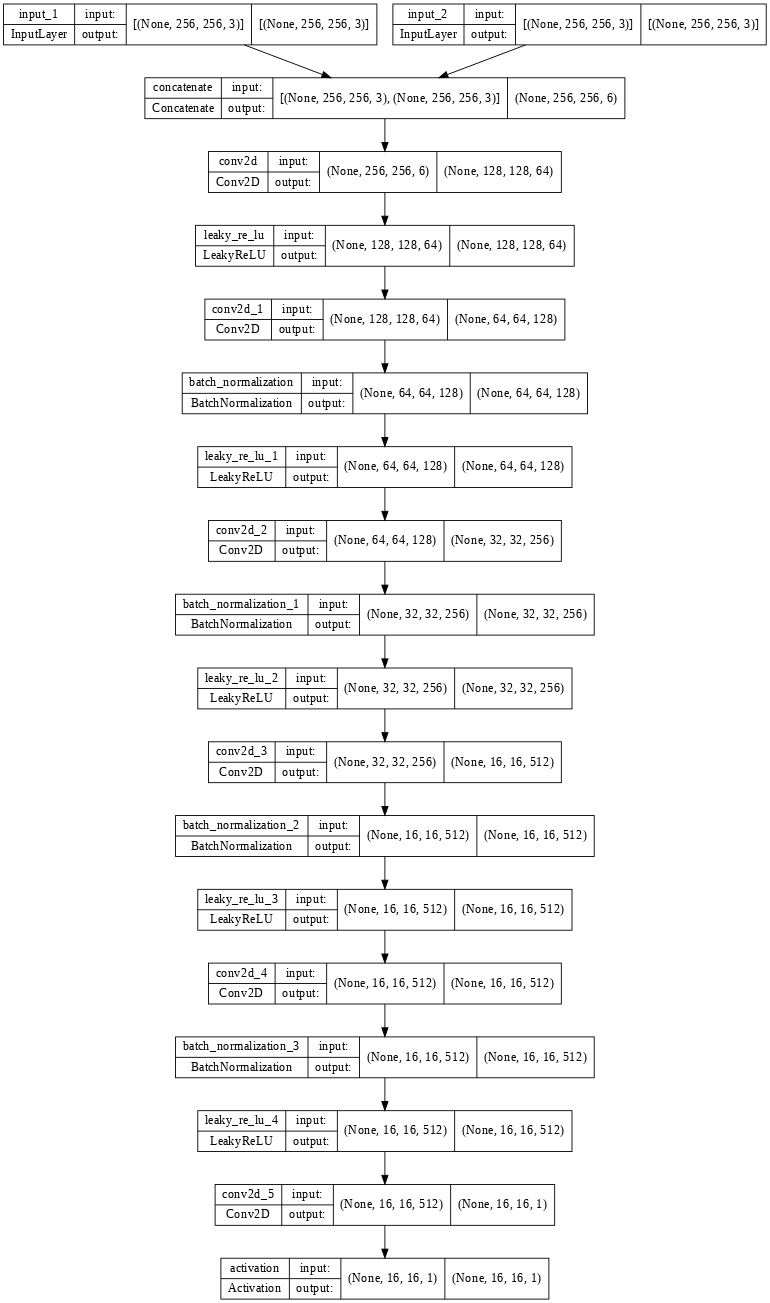

In [ ]:
plot_model(d_model, show_shapes=True, dpi=64)

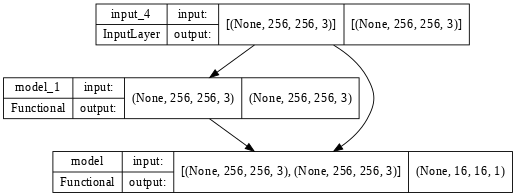

In [ ]:
plot_model(gan_model, show_shapes=True, dpi=64)

In [ ]:
def split_image(image, rows, columns):
  image = (image + 1) / 2.0
  grid = []
  horizontal_size = int(image.shape[0] / columns)
  vertical_size = int(image.shape[1] / rows)
  for i in range(rows):
    image_row = []
    for j in range(columns):
      start = (i * vertical_size, j * horizontal_size)
      end = ((i + 1) * vertical_size, (j + 1) * horizontal_size)
      current_section = image[start[0]:end[0], start[1]:end[1]]
      # pyplot.imshow(current_section, cmap='gray')
      # pyplot.show()
      image_row.append(current_section)
    grid.append(image_row)
  return grid

In [ ]:
def grid_ssim(first_grid, second_grid):
  assert(len(first_grid) == len(second_grid))
  assert(len(first_grid[0]) == len(second_grid[0]))
  ssim_grid = []
  for i in range(len(first_grid)):
    ssim_row = []
    for j in range(len(first_grid[i])):
      ssim_row.append(calculate_ssim(first_grid[i][j], second_grid[i][j]))
    ssim_grid.append(ssim_row)
  return ssim_grid

In [ ]:
from os import mkdir

mkdir("result_images")

In [ ]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load, vstack
import numpy as np
from matplotlib import pyplot
from numpy.random import randint

from skimage import data, img_as_float
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error

# from skimage.color import rgb2gray
from csv import writer
from itertools import chain
from os import path
import cv2


# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
# def plot_images(gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i], cmap='gray')
		# show title
		pyplot.title(titles[i])
	pyplot.show()
 
def split_top_down(image):
	top_half = image[0:int(image.shape[1]/2), 0:]
	bottom_half = image[int(image.shape[1]/2):, 0:]
	return top_half, bottom_half

def calculate_ssim(first_img, second_img):
	# return structural_similarity(first_img, second_img, 
	#                              multichannel=True, data_range=second_img.max() - second_img.min())
	return structural_similarity(first_img, second_img, 
	                             multichannel=True, data_range=second_img.max() - second_img.min())

def top_bottom_ssim(src_img, given_img):
	src_img = np.squeeze(src_img)
	given_img = np.squeeze(given_img)
 
	(top_src_img, bottom_src_img) = split_top_down(src_img)
	(top_given_img, bottom_given_img) = split_top_down(given_img)
	
	ssim_top = calculate_ssim(top_src_img, top_given_img)
	ssim_bottom = calculate_ssim(bottom_src_img, bottom_given_img)
	ssim_complete = calculate_ssim(src_img, given_img)
	return ssim_top, ssim_bottom, ssim_complete

def evaluate_generation(src_img, tar_img, gen_img, threshold = 0.035):
	tar_ssim  = list(top_bottom_ssim(src_img, tar_img))
	gen_ssim = list(top_bottom_ssim(src_img, gen_img))
	ssim_differences = [abs(element - gen_ssim[index]) <= threshold for (index, element) in enumerate(tar_ssim)]
	return ssim_differences

def compare_target_generated(gen_img, tar_img, threshold = 0.8):
	tar_gen_ssim = list(top_bottom_ssim(tar_img, gen_img))
	return [half >= 0.8 for half in tar_gen_ssim]

def plot_grid_images(image_grid):
	counter = 0
	for image_row in image_grid:
		for image in image_row:
			# define subplot
			pyplot.subplot(len(image_grid), len(image_grid[0]), 1 + counter)
			counter += 1
			# turn off axis
			pyplot.axis('off')
			# plot raw pixel data
			pyplot.imshow(image, cmap='gray')
	pyplot.show()

# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
# name = 'first-last-0.3-256x256-no525_names'
# name = 'one-year-0.3-256x256-no525-names'
name = 'six-months-0.3-256x256-no525-names'
# root_path = 'Resultados/Final/first-last-0.3-256x256/first-last-0.3-256x256-no525_names'
# root_path = 'Resultados/Final/One-year-0.3-256x256-no525-names/one-year-0.3-256x256-no525-names'
root_path = 'six-months-0.3-256x256-no525-names'
test_filename = root_path + '-test.npz'


# load dataset
[X1, X2] = load_real_samples(test_filename)
print('Loaded', X1.shape, X2.shape)
# load model
# model = load_model('Resultados/Final/first-last-0.3-256x256/model_005400.h5')

model = load_model('models/model_001220.h5')

# model.compile()
# select random example
# ix = randint(0, len(X1), 1)
src_top_hits = src_bottom_hits = src_complete_hits = 0
top_hits = bottom_hits = complete_hits = 0
results = []
structure_similarity_indices = []
images = []
for ix in range(len(X1)):
	src_image, tar_image = X1[[ix]], X2[[ix]]

	# generate image from source
	gen_image = model.predict(src_image)

	# plot all three images
	plot_images(src_image, gen_image, tar_image)
	src_image = np.squeeze(src_image)
	tar_image = np.squeeze(tar_image)
	gen_image = np.squeeze(gen_image)

	generated_image = (gen_image + 1) / 2.0
	source_image = (src_image + 1) / 2.0
	target_image = (tar_image + 1) / 2.0

	images.append((generated_image, 'fake'))
 

	# pyplot.axis('off')
	# pyplot.imshow(source_image)
	# pyplot.savefig(path.join('result_images', f'{ix}_source.jpg'), figsize=(256, 256), bbox_inches='tight')
	# pyplot.close()
	# pyplot.axis('off')
	# pyplot.imshow(target_image)
	# pyplot.savefig(path.join('result_images', f'{ix}_generated.jpg'), figsize=(256, 256), bbox_inches='tight')
	# pyplot.close()
	# pyplot.axis('off')
	# pyplot.imshow(generated_image)
	# pyplot.savefig(path.join('result_images', f'{ix}_target.jpg'), figsize=(256, 256), bbox_inches='tight')
	# pyplot.close()

	grid_rows = grid_columns = 3
	src_grid = split_image(src_image, grid_rows, grid_columns)
	# plot_grid_images(src_grid)
	tar_grid = split_image(tar_image, grid_rows, grid_columns)
	gen_grid = split_image(gen_image, grid_rows, grid_columns)
	
	src_tar_grid_ssim = grid_ssim(src_grid, tar_grid)
	src_gen_grid_ssim = grid_ssim(src_grid, gen_grid)
	tar_gen_grid_ssim = grid_ssim(tar_grid, gen_grid)
 
	src_tar_ssim = calculate_ssim(src_image, tar_image)
	src_gen_ssim = calculate_ssim(src_image, gen_image)
	tar_gen_ssim = calculate_ssim(tar_image, gen_image)
	# src_tar_ssim = list(top_bottom_ssim(src_image, tar_image))
	# src_gen_ssim = list(top_bottom_ssim(src_image, gen_image))
	# tar_gen_ssim = list(top_bottom_ssim(tar_image, gen_image))

	# print(f'Source Target ssim: {src_tar_ssim}')
	# print(f'Source Generated ssim: {src_gen_ssim}')
	# print(f'Target Generated ssim: {tar_gen_ssim}')
	# src_tar_tags = [f'src_tar_{i}' for i in range(grid_rows*grid_columns)]
	# src_gen_tags = [f'src_gen_{i}' for i in range(grid_rows*grid_columns)]
	# tar_gen_tags = [f'tar_gen_{i}' for i in range(grid_rows*grid_columns)]
	# current_result = {"Source_target": src_tar_grid_ssim, "Source_generated": src_gen_grid_ssim, "Target_generated": tar_gen_grid_ssim}

	# current_result = src_tar_ssim + src_gen_ssim + tar_gen_ssim
	
	# current_result = dict(zip(src_tar_tags + src_gen_tags + tar_gen_tags, chain(*(src_tar_grid_ssim + src_gen_grid_ssim + tar_gen_grid_ssim))))
	current_result = [src_tar_ssim] + list(chain(*(src_tar_grid_ssim))) + [src_gen_ssim] + list(chain(*(src_gen_grid_ssim))) + [tar_gen_ssim] + list(chain(*(tar_gen_grid_ssim)))
	
	results.append(current_result)
	# print(len(current_result))
	
	# !!! important
	# evaluation_result = evaluate_generation(src_image, tar_image, gen_image, 0.05)
	# src_top_success = False
	# if evaluation_result[0]:
	# 	src_top_hits += 1
	# 	src_top_success = True
	# if evaluation_result[1]:
	# 	src_bottom_hits += 1
	# 	if src_top_success:
	# 		src_complete_hits += 1

	# target_generation_success = compare_target_generated(tar_image, gen_image, 0.75)
	# # print(target_generation_success)
	# top_success = False
	# if target_generation_success[0]:
	# 	top_hits += 1
	# 	top_success = True
	# if target_generation_success[1]:
	# 	bottom_hits += 1
	# 	if top_success:
	# 		complete_hits += 1

# batch_size = X1.shape[0]
# print(results)
# print(f"Source: Top score = {src_top_hits}/{batch_size} Bottom score = {src_bottom_hits}/{batch_size} Image score = {src_complete_hits}/{batch_size}")
# print(f"Top score = {top_hits}/{batch_size} Bottom score = {bottom_hits}/{batch_size} Image score = {complete_hits}/{batch_size}")
# print(results)
# average_ssim = sum(structure_similarity_indices)/len(structure_similarity_indices)
# print(f"Average Structural Similarity: {average_ssim:.2}")

src_tar_tags = [f'src_tar_{i}' for i in range(grid_rows*grid_columns)]
src_gen_tags = [f'src_gen_{i}' for i in range(grid_rows*grid_columns)]
tar_gen_tags = [f'tar_gen_{i}' for i in range(grid_rows*grid_columns)]

# header = ["Source_target_top", "Source_target_bottom", "Source_target_complete",
#           "Source_generated_top", "Source_generated_bottom", "Source_generated_complete",
# 					"Target_generated_top", "Target_generated_bottom", "Target_generated_complete"]

header = ["src_tar_complete"] + src_tar_tags + ["src_gen_complete"] + src_gen_tags + ["tar_gen_complete"] + tar_gen_tags

with open(name + '.csv', 'w') as f:
    writer = writer(f)
    writer.writerow(header)
    writer.writerows(results)

Loaded (26, 256, 256, 3) (26, 256, 256, 3)


OSError: ignored

In [ ]:
!zip -r first-last-result-images.zip result_images

In [ ]:
images

In [ ]:
import random
root_path = 'Resultados/Final/first-last-0.3-256x256/first-last-0.3-256x256-no525_names'
train_filename = root_path + '-train.npz'
[X1, X2] = load_real_samples(train_filename)
print('Loaded', X1.shape, X2.shape)
real_images = []
for ix in range(len(X1)):
  src_image, tar_image = X1[[ix]], X2[[ix]]
  target_image = np.squeeze(tar_image)
  target_image = (target_image + 1) / 2.0
  real_images.append((target_image, 'real'))

images += random.sample(real_images, len(images))

Loaded (54, 256, 256, 3) (54, 256, 256, 3)


In [ ]:
# !mkdir real-fake-images
random.shuffle(images)
tags = [pair[1] for pair in images]
!echo $tags > real-fake-tags.txt
for ix, pair in enumerate(images):
  image, tag = pair
  pyplot.axis('off')
  pyplot.imshow(image)
  pyplot.savefig(path.join('real-fake-images', f'{ix}.jpg'), figsize=(256, 256), bbox_inches='tight')
  pyplot.close()

In [ ]:
# !zip generated_samples.zip -r generated_samples
!zip -r real-fake-images.zip real-fake-images

In [ ]:
!rm -rf real-fake-images.zip
!rm -rf real-fake-images

In [ ]:
import pandas
tag_df = pandas.DataFrame(tags, columns=['Tag'])
tag_df.to_csv('real-fake-tags.csv')

In [ ]:

src = src_image.squeeze()
tar = tar_image.squeeze()

src_grid = split_image(src, 3, 3)
tar_grid = split_image(tar, 3, 3)

ssim_grid = grid_ssim(src_grid, tar_grid)
print(ssim_grid)
src_tar_tags = [f'src_tar_{i}' for i in range(3*3)]
src_gen_tags = [f'src_gen_{i}' for i in range(3*3)]
print(dict(zip(src_tar_tags + src_gen_tags, chain(*(ssim_grid + ssim_grid)))))

[[0.7651255035913825, 0.7968750639131351, 0.8350197966536879], [0.7688039490198014, 0.7629062127955644, 0.8472975011216185], [0.8224530938970953, 0.8708337405693124, 0.866386564433336]]
{'src_tar_0': 0.7651255035913825, 'src_tar_1': 0.7968750639131351, 'src_tar_2': 0.8350197966536879, 'src_tar_3': 0.7688039490198014, 'src_tar_4': 0.7629062127955644, 'src_tar_5': 0.8472975011216185, 'src_tar_6': 0.8224530938970953, 'src_tar_7': 0.8708337405693124, 'src_tar_8': 0.866386564433336, 'src_gen_0': 0.7651255035913825, 'src_gen_1': 0.7968750639131351, 'src_gen_2': 0.8350197966536879, 'src_gen_3': 0.7688039490198014, 'src_gen_4': 0.7629062127955644, 'src_gen_5': 0.8472975011216185, 'src_gen_6': 0.8224530938970953, 'src_gen_7': 0.8708337405693124, 'src_gen_8': 0.866386564433336}


In [ ]:
from google.colab import files
files.download('six-months-0.3-256x256-no525-names-train.npz')
# files.download(name + '.csv')
# files.download(name + '_order.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

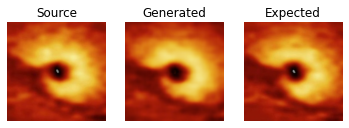

In [ ]:
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)